In [2]:
import mne
import os
import scipy.io
import listen_italian_functions
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib as mpl
from mne.stats import permutation_cluster_test
from mne.stats import permutation_cluster_1samp_test
from functools import partial
from mne.stats import ttest_1samp_no_p, permutation_t_test,fdr_correction
from IPython.display import clear_output
from itertools import permutations,combinations
sns.set(style="darkgrid")
sns.set(font_scale=1.5)


data_path = os.path.dirname(os.getcwd())

subject_name = ['Alice','Andrea','Daniel','Elena','Elenora','Elisa','Federica','Francesca','Gianluca1','Giada','Giorgia',
                'Jonluca','Laura','Leonardo','Linda','Lucrezia','Manu','Marco','Martina','Pagani','Pasquale','Sara',
                'Silvia','Silvia2','Tommaso']


trial_len = 2
remove_first = 0.5 #seconds

save_path = data_path + '/data/coherence'

info = mne.io.read_raw_fif((save_path+'-info'),preload=True)


Opening raw data file C:\Users\SMukherjee\Desktop\projects\listen_italian_motor_entrainment\analysis\python\data\coherence-info...
This filename (C:\Users\SMukherjee\Desktop\projects\listen_italian_motor_entrainment\analysis\python\data\coherence-info) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
    Range : 40502 ... 1132918 =     40.502 ...  1132.918 secs
Ready.
Reading 0 ... 1092416  =      0.000 ...  1092.416 secs...


# coherence 

In [107]:
save_path = data_path + '/data/coherence/Coh-removedFirst-'+ str(remove_first)+'.pkl'
data=pd.read_pickle(save_path)

a  = data['Data'].apply(lambda x: np.mean(x))
data['Coherence'] = pd.Series(a, index=data.index)

a  = data['Freq'].apply(lambda x:  float(x.split(' ')[3].replace('Hz','')) )
data['Freqi'] = pd.Series(a, index=data.index)

data.set_index(['Feature','Freqi','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)

a = pd.DataFrame(data.reset_index())
freq = a.Freq.unique()
print(freq)

data.sample(4)


['fr 0.25 - 1Hz' 'fr 0.5 - 2Hz' 'fr 1 - 3Hz' 'fr 1 - 4Hz' 'fr 2 - 6Hz'
 'fr 4 - 8Hz' 'fr 8 - 12Hz' 'fr 12 - 18Hz' 'fr 18 - 24Hz' 'fr 24 - 40Hz']


,,,,,Data,Freq,noTrials,Coherence
Feature,Freqi,Condition,Delay,Subject,,,,
envelop,24.0,All,-0.2,Martina,"[0.030424384722726655, 0.01085119101810113, 0....",fr 18 - 24Hz,123,0.022622
lipProtrusion,4.0,All,0.4,Elisa,"[0.043420064666393844, 0.02962710227839585, 0....",fr 1 - 4Hz,114,0.030681
envelop,3.0,All,0.4,Silvia,"[0.04031248851608055, 0.03237166568586031, 0.0...",fr 1 - 3Hz,120,0.041815
TMCD,18.0,All,-0.5,Silvia2,"[0.034518330160754056, 0.03176174070765574, 0....",fr 12 - 18Hz,118,0.035961


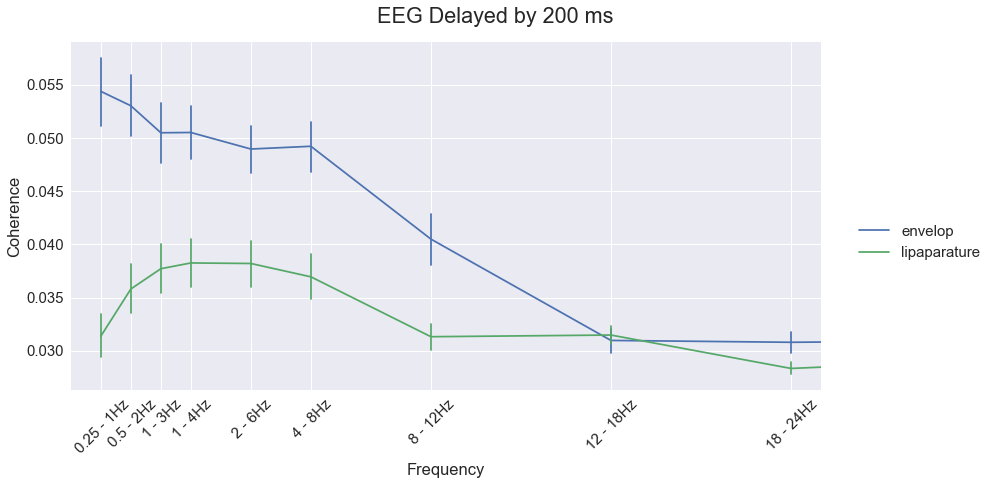

In [112]:
a = pd.DataFrame(data.reset_index())
fi = np.sort(a.Freqi.unique())
freq = a.Freq.unique()
freq = [w.replace('fr', '') for w in freq]

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['envelop','lipaparature']

condition = ['All']

delay = [0.2]

a = data.loc[extra_channels,fi,condition,delay,subject_name]['Coherence']
a = pd.DataFrame(a.reset_index())

sns.set(style="darkgrid")
sns.set(font_scale=1.5)
#sns.set_style("ticks", {"xtick.major.size": 2, "ytick.major.size": 8})
#sns.set_style('darkgrid', {'grid.linewidth': .5,'axes.facecolor': '.9'})

g = sns.FacetGrid(a,  margin_titles=True,size=6,aspect=2)
b = g.map_dataframe(sns.tsplot, time="Freqi", unit="Subject",condition="Feature", value="Coherence",
                    color="deep", err_style="ci_bars").add_legend()
b = b.set_xlabels('Frequency')
b = b.set_ylabels('Coherence')
#b.ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
#b.ax.grid(b=True, which='minor', color='w', linewidth=0.5)
b.fig.subplots_adjust(top=0.9)
b.fig.suptitle('EEG Delayed by 200 ms')
b.set(xticks=fi,xlim=(0, 25))
b.set_xticklabels(freq,rotation=45)


# surrogate coherence

In [54]:
save_path = data_path + '/data/coherence/Coh-removedFirst-'+ str(remove_first)+'.pkl'
data=pd.read_pickle(save_path)
data.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)

# read surrogate coherence
save_path = data_path + '/data\SurrogateCoherence/SurrogateCoherence-removedFirst-'+ str(remove_first)+'-envelop-lipaparature.pkl'
data_surrogate=pd.read_pickle(save_path)
data_surrogate.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data_surrogate.sort_index(inplace=True)

a  = data_surrogate['Data'].apply(lambda x: np.mean(x,axis=1))
data_surrogate['mean_data'] = pd.Series(a, index=data_surrogate.index)

a = pd.DataFrame(data_surrogate.reset_index())
freq = a.Freq.unique()
print(freq)
a = pd.DataFrame(data.reset_index())
freq = a.Freq.unique()
print(freq)
data_surrogate.sample(5)

['fr 0.25 - 1Hz' 'fr 0.5 - 2Hz' 'fr 1 - 3Hz' 'fr 1 - 4Hz' 'fr 12 - 18Hz'
 'fr 18 - 24Hz' 'fr 2 - 6Hz' 'fr 24 - 40Hz' 'fr 4 - 8Hz' 'fr 8 - 12Hz']
['fr 0.25 - 1Hz' 'fr 0.5 - 2Hz' 'fr 1 - 3Hz' 'fr 1 - 4Hz' 'fr 12 - 18Hz'
 'fr 18 - 24Hz' 'fr 2 - 6Hz' 'fr 24 - 40Hz' 'fr 4 - 8Hz' 'fr 8 - 12Hz']


Data  \
Feature      Freq          Condition Delay Subject                                                        
lipaparature fr 24 - 40Hz  All       -0.2  Alice      [[0.02788645369505835, 0.029248999552868377, 0...   
             fr 12 - 18Hz  All        0.3  Gianluca1  [[0.02178353597706507, 0.024743223270064434, 0...   
             fr 0.25 - 1Hz All        0.5  Leonardo   [[0.047858519445621736, 0.03466320399630604, 0...   
envelop      fr 8 - 12Hz   All       -0.5  Pasquale   [[0.025821440175771, 0.04551103305564152, 0.04...   
lipaparature fr 1 - 3Hz    All        0.0  Andrea     [[0.02961044336952554, 0.03836710436628277, 0....   

                                                      no_surrogates  \
Feature      Freq          Condition Delay Subject                    
lipaparature fr 24 - 40Hz  All       -0.2  Alice                123   
             fr 12 - 18Hz  All        0.3  Gianluca1            119   
             fr 0.25 - 1Hz All        0.5  Leonardo             118   
envelop      fr 8 - 12Hz   All       -0.5  Pasquale             116   
lipaparature fr 1 - 3Hz    All        0.0  Andrea               120   

                                                                                              mean_data  
Feature      Freq          Condition Delay Subject                                                       
lipaparature fr 24 - 40Hz  All       -0.2  Alice      [0.030060917492385517, 0.03020288572668722, 0....  
             fr 12 - 18Hz  All        0.3  Gianluca1  [0.0323838437026594, 0.03247996712855739, 0.03...  
             fr 0.25 - 1Hz All        0.5  Leonardo   [0.03203984241790218, 0.033440360872297334, 0....  
envelop      fr 8 - 12Hz   All       -0.5  Pasquale   [0.03166798055815863, 0.03160828555022369, 0.0...  
lipaparature fr 1 - 3Hz    All        0.0  Andrea     [0.033370389301567265, 0.03350582685497495, 0....

# debias and t-test (non parametric)


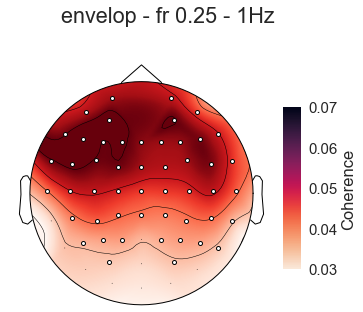

In [56]:
features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']

features = ['envelop']
condition = ['All']
delay = [0.2]
freq_band = [ 'fr 0.25 - 1Hz']

debiased_coh = []
original_coh = []

for s in subject_name:
    A = data.loc[features,freq_band,condition,delay,s]['Data'].get_values()
    B = data_surrogate.loc[features,freq_band,condition,delay,s]['mean_data'].get_values()
    original_coh.append(A[0])
    A = A[0] - B[0]
    debiased_coh.append(A)
    
debiased_coh = np.asarray(debiased_coh)
original_coh = np.asarray(original_coh)

P = [0] * 59
T = [0] * 59
for ch in range(0,59):
    t,p = scipy.stats.wilcoxon(debiased_coh[:,ch])
    P[ch] = p/2 # onesided
    T[ch] = t

mask, adj_p = fdr_correction(P, alpha=0.05, method='indep')  
A = original_coh.mean(axis=0)
vmin = np.round(min(A),decimals=2)
vmax = np.round(max(A),decimals=2)
df = pd.DataFrame({'Data':[A],'mask':[mask],'p-value':[P],'t-stat':[T]})

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].any() 
    mask = data['mask'].any()
    mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax,mask = mask)

sns.set(style="darkgrid")
sns.set(font_scale=1.5)
fg = sns.FacetGrid(df,margin_titles=True,size=5)
b = fg.map_dataframe(draw_heatmap, 'Data')
b = b.set_xlabels('')
#b.fig.subplots_adjust(top=0.7)
b.fig.subplots_adjust(right=0.8)
b.fig.suptitle(features[0]+' - '+freq_band[0])

cbar_ax = b.fig.add_axes([0.82,0.25,0.05,0.45]) # [left, bottom, width, height] 
#colorbar
cmap = plt.get_cmap()
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap.reversed(), norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax,label='Coherence')

# figure 3 [all dealy significance]

In [57]:
def plot_significant_coherence_channel_delay(data,data_surrogate,features,freq_band,condition,d,subject_name):
    frames = []
    value = []
    for d in range(0,len(delay)):
        A,T, P,vmin,vmax = compute_cluster_permutation_coherence_surrogate(data,data_surrogate,features,
                                                             freq_band,condition,delay[d],subject_name)
        mask, adj_p = fdr_correction(P, alpha=0.05, method='indep')  

        df = pd.DataFrame({'Data':[A],'p-value':[P],'T-stat':[T],'Delay':delay[d],'mask':[mask]})
        frames.append(df)
        value.append(vmin)
        value.append(vmax)

    df=pd.concat((frames),axis=0)
    return df,value

def compute_cluster_permutation_coherence_surrogate(data,data_surrogate,features,freq_band,condition,delay,subject_name):
    
    debiased_coh = []
    original_coh = []
    for s in subject_name:
        A = data.loc[features,freq_band,condition,delay,s]['Data'].get_values()
        B = data_surrogate.loc[features,freq_band,condition,delay,s]['mean_data'].get_values()
        original_coh.append(A[0])
        A = A[0] - B[0]
        debiased_coh.append(A)
    
    debiased_coh = np.asarray(debiased_coh)
    original_coh = np.asarray(original_coh)
    P = [0] * 59
    T = [0] * 59
    for ch in range(0,59):
        t,p = scipy.stats.wilcoxon(debiased_coh[:,ch])
        #P[ch] = np.round(p,decimals=4)
        #T[ch] = np.round(t,decimals=4)
        P[ch] = p/2 # onesided
        T[ch] = t
        
    A = original_coh.mean(axis=0)
    vmin = min(A)
    vmax = max(A)

    return A,T, P,vmin,vmax



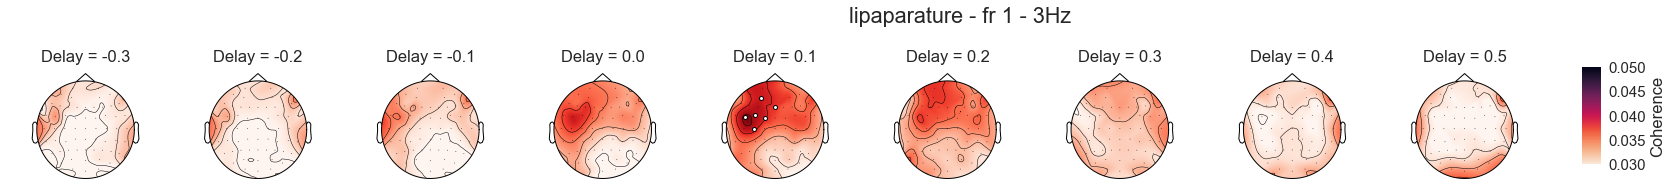

In [79]:
features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
features = ['lipaparature']
condition = ['All']
delay = np.arange(-3,6) / 10
freq_band = [ 'fr 1 - 3Hz']

df,A = plot_significant_coherence_channel_delay(data,data_surrogate,features,freq_band,condition,delay,subject_name)

vmin = np.round(min(A),decimals=2)
vmax = np.round(max(A),decimals=2)

P = []
for d in range(0,len(delay)):
    P.append(df['p-value'].get_values()[d])
    
P = np.asarray(P)
mask, adj_p = fdr_correction(P, alpha=0.05, method='indep')  

P = []
for d in range(0,len(delay)):
    P.append(pd.DataFrame({'mask':[mask[d,:]]}))
P=pd.concat((P),axis=0)
df['maskC'] = P['mask'].get_values()


def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].any() 
    mask = data['maskC'].any()
    mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax,mask = mask)

sns.set(style="darkgrid")
sns.set(font_scale=1.5)
fg = sns.FacetGrid(df,col='Delay',margin_titles=True)
b = fg.map_dataframe(draw_heatmap, 'Data')
b = b.set_xlabels('')
b.fig.subplots_adjust(top=0.7)
b.fig.subplots_adjust(right=0.8)
b.fig.suptitle(features[0]+' - '+freq_band[0])

cbar_ax = b.fig.add_axes([0.82,0.25,0.01,0.45]) # [left, bottom, width, height] 
#colorbar
cmap = plt.get_cmap()
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap.reversed(), norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax,label='Coherence')

# figure 4

In [125]:
def get_P_value_coherence(data,extra_channels,freq_band,condition,delay,subject_name,numSamples):
    A = []
    
    for c in condition:
        for fr in freq_band:        
            for d in delay:
                group1 = data.loc[extra_channels[0],fr,c,d,subject_name]['Coherence']
                group2 = data.loc[extra_channels[1],fr,c,d,subject_name]['Coherence']
                a = run_permutation_test2(group1.get_values(),group2.get_values(),numSamples)
                p = pd.DataFrame({'Delay':d,'Freq':fr,'Condition':c,'FeatureTest':[extra_channels],'p-value':a})
                A.append(p)
                
    P = pd.concat((A),axis=0)
    return P   

def run_permutation_test2(x,y,numSamples):
    #keeping the subject association
    pooled = np.vstack([x,y]).T
    d0 = abs(x.mean() - y.mean())
    d = np.zeros((numSamples,))
    for k in range(numSamples):
        for i in range(len(x)):
            a = pooled[i]
            np.random.shuffle(a)
            pooled[i] = a
            
        starZ = pooled[:,0]
        starY = pooled[:,1]    
        d[k] = abs(starZ.mean() - starY.mean())

    p = len(np.where( d > d0 )[0])
    p = p / float(numSamples)
    p = np.round(p,decimals=3)

    return p  

(array([False, False, False, False, False,  True, False,  True,  True,
         True, False]),
 array([0.7766    , 0.72111111, 0.4576    , 0.72111111, 0.72111111,
        0.033     , 0.866     , 0.00366667, 0.        , 0.        ,
        0.72111111]))

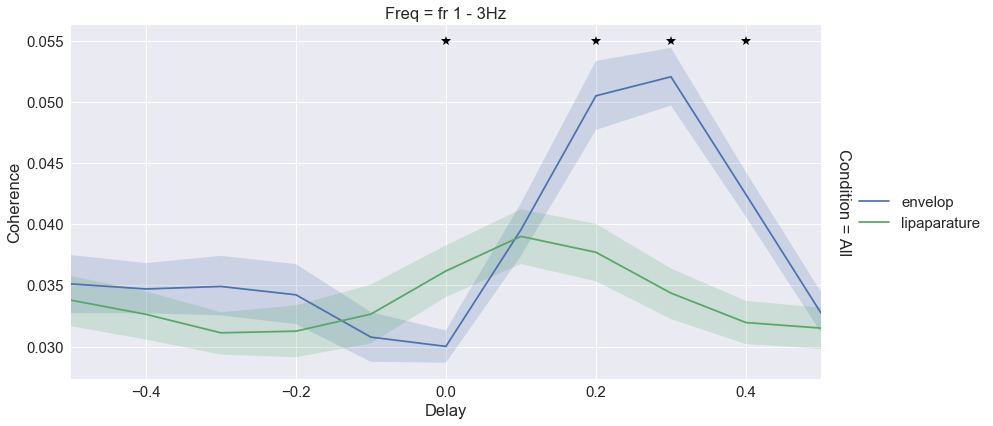

In [127]:
save_path = data_path + '/data/coherence/Coh-removedFirst-'+ str(remove_first)+'.pkl'
data=pd.read_pickle(save_path)
a  = data['Data'].apply(lambda x: np.mean(x))
data['Coherence'] = pd.Series(a, index=data.index)
data.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)

freq_band = [ 'fr 1 - 3Hz']
#freq_band = ['fr 1 - 3Hz', 'fr 2 - 4Hz', 'fr 3 - 5Hz', 'fr 4 - 6Hz','fr 5 - 7Hz', 'fr 6 - 8Hz', 'fr 7 - 9Hz', 'fr 8 - 10Hz',
# 'fr 9 - 11Hz', 'fr 10 - 12Hz']

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['envelop','lipaparature']

condition = ['Hyper','Normal','Hypo','All']
condition = ['All']

delay = np.arange(-5,6) / 10

a = data.loc[extra_channels,freq_band,condition,delay,subject_name]['Coherence']
a = pd.DataFrame(a.reset_index())

# permutation stat
numSamples = 1000
P = get_P_value_coherence(data,extra_channels,freq_band,condition,delay,subject_name,numSamples)
x = P[P['p-value'] <= 0.05]['Delay'].get_values()
y = np.repeat(0.055,len(x))

g = sns.FacetGrid(a, col="Freq", row="Condition",col_order=freq_band , margin_titles=True,size=6,aspect=2)
b = g.map_dataframe(sns.tsplot, time="Delay", unit="Subject",condition="Feature", value="Coherence",color="deep").add_legend()
b = b.set_xlabels('Delay')
b = b.set_ylabels('Coherence')
# mark the signifiancant point
x = plt.plot(x,y, marker='*', color='k',markersize=10,linestyle='')

fdr_correction(P['p-value'].get_values(), alpha=0.05, method='indep')

# partial Coherence

In [83]:
save_path = data_path + '/data/partialCoh/PartialCoh-removedFirst-'+ str(remove_first)+'.pkl'
data=pd.read_pickle(save_path)
data.set_index(['Feature','FeatureDelay','RemoveFeature','RemoveFeatureDelay',
                        'Freq','Condition','Subject'], inplace=True)
data.sort_index(inplace=True)
a  = data['Data'].apply(lambda x: np.mean(x))
data['partialCoh'] = pd.Series(a, index=data.index)
data.sample(5)

Data  \
Feature      FeatureDelay RemoveFeature RemoveFeatureDelay Freq          Condition Subject                                                        
lipaparature  0.0         envelop        0.0               fr 4 - 8Hz    All       Francesca  [0.0005058995984456747, 0.00046410826260078603...   
              0.1         envelop        0.1               fr 1 - 3Hz    All       Daniel     [0.002275482594826196, 0.0014735162087886281, ...   
             -0.5         envelop       -0.5               fr 18 - 24Hz  All       Pasquale   [0.0006270947194842809, 0.0004151972479141794,...   
              0.3         envelop        0.3               fr 0.25 - 1Hz All       Pagani     [0.00010687721903975716, 0.0002457071368860484...   
             -0.4         envelop       -0.4               fr 18 - 24Hz  All       Linda      [0.0009980101479002933, 0.000862166858753262, ...   

                                                                                              partialCoh  
Feature      FeatureDelay RemoveFeature RemoveFeatureDelay Freq          Condition Subject                
lipaparature  0.0         envelop        0.0               fr 4 - 8Hz    All       Francesca    0.000361  
              0.1         envelop        0.1               fr 1 - 3Hz    All       Daniel       0.000828  
             -0.5         envelop       -0.5               fr 18 - 24Hz  All       Pasquale     0.000701  
              0.3         envelop        0.3               fr 0.25 - 1Hz All       Pagani       0.001754  
             -0.4         envelop       -0.4               fr 18 - 24Hz  All       Linda        0.000850

In [84]:
def run_permutation_test2(x,y,numSamples):
    #keeping the subject association
    pooled = np.vstack([x,y]).T
    d0 = abs(x.mean() - y.mean())
    d = np.zeros((numSamples,))
    for k in range(numSamples):
        for i in range(len(x)):
            a = pooled[i]
            np.random.shuffle(a)
            pooled[i] = a
            
        starZ = pooled[:,0]
        starY = pooled[:,1]    
        d[k] = abs(starZ.mean() - starY.mean())

    p = len(np.where( d > d0 )[0])
    p = p / float(numSamples)
    p = np.round(p,decimals=5)

    return p    
def get_P_value2(data,feat_comb,freq_band,condition,delay,subject_name):
    A = []    
    for c in condition:
        for fr in freq_band:        
            for d in delay:
                group1 = data.loc[feat_comb[0][0],d,feat_comb[0][1],d,fr,c,subject_name]['partialCoh']
                group2 = data.loc[feat_comb[1][0],d,feat_comb[1][1],d,fr,c,subject_name]['partialCoh']
                p = run_permutation_test2(group1.get_values(),group2.get_values(),1000)
                a = pd.DataFrame({'Delay':d,'Freq':fr,'Condition':c,'p-value':[p]})
                A.append(a)
                
    P = pd.concat((A),axis=0)
    return P    

(array([False, False, False, False, False,  True, False,  True,  True,
         True, False]),
 array([0.851     , 0.848375  , 0.4906    , 0.848375  , 0.848375  ,
        0.02475   , 0.851     , 0.00366667, 0.        , 0.00366667,
        0.851     ]))

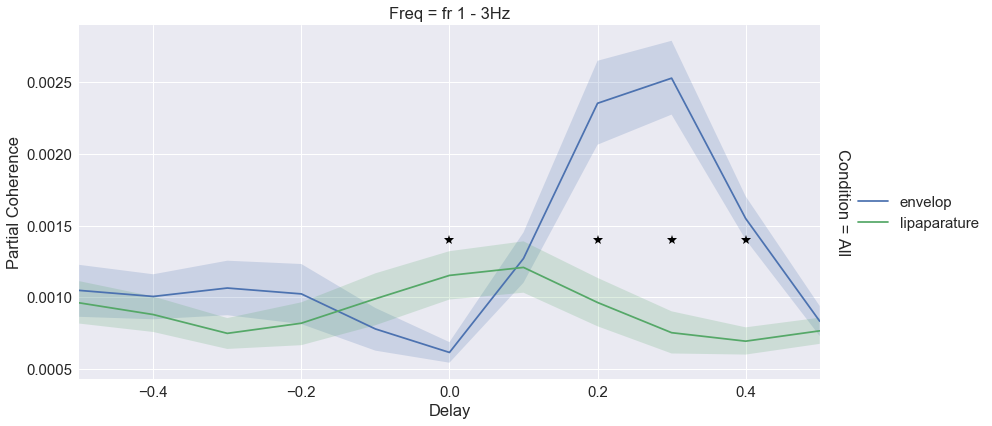

In [85]:
freq_band = [ 'fr 1 - 3Hz']
features = ['envelop','lipaparature']
Removedfeatures = ['envelop','lipaparature']
feat_comb = (['envelop','lipaparature'],['lipaparature','envelop'])
condition = ['All']

delay = np.arange(-5,6) / 10

# select the best one Channel
column_name = ('FC5')

i = info.ch_names.index(column_name)
a  = data['Data'].apply(lambda x: np.mean(x[i]))
#data['partialCoh'] = pd.Series(a, index=data.index)

frame  = []
for d in delay:
    a = data.loc[features,d,Removedfeatures,d,freq_band,condition,subject_name]['partialCoh']
    frame.append(pd.DataFrame(a))
    
aa = pd.concat((frame),axis=0)

a = aa.loc[features,delay,Removedfeatures,delay,freq_band,condition,subject_name]['partialCoh']
a = pd.DataFrame(a.reset_index())


# stat
P = get_P_value2(aa,feat_comb,freq_band,condition,delay,subject_name)
x = P[P['p-value'] <= 0.05]['Delay'].get_values()
y = np.repeat(0.0014,len(x))

g = sns.FacetGrid(a, col="Freq", row="Condition",col_order=freq_band , margin_titles=True,size=6,aspect=2)
b = g.map_dataframe(sns.tsplot, time="FeatureDelay", unit="Subject",condition="Feature", value='partialCoh',color="deep").add_legend()
b = b.set_xlabels('Delay')
#b = b.set_ylabels('Partial Coherence ('+'-'.join(column_name)+')')
b = b.set_ylabels('Partial Coherence')

# mark the signifiancant point
x = plt.plot(x,y, marker='*', color='k',markersize=10,linestyle='')

fdr_correction(P['p-value'].get_values(), alpha=0.05, method='indep')

# debias and t-test (non parametric)

In [86]:
# read surrogate coherence
save_path = data_path + '/data/partialCoh/Surrogate_PartialCoh-removedFirst-'+ str(remove_first)+'-envelop-lipaparature.pkl'
data_surrogate=pd.read_pickle(save_path)
a  = data_surrogate['Data'].apply(lambda x: np.mean(x,axis=1))
data_surrogate['mean_data'] = pd.Series(a, index=data_surrogate.index)

data_surrogate.set_index(['Feature','FeatureDelay','RemoveFeature','RemoveFeatureDelay',
                        'Freq','Condition','Subject'], inplace=True)
data_surrogate.sort_index(inplace=True)
a  = data_surrogate['mean_data'].apply(lambda x: np.mean(x))
data_surrogate['partialCoh'] = pd.Series(a, index=data_surrogate.index)

a = pd.DataFrame(data_surrogate.reset_index())
freq = a.Freq.unique()
print(freq)

data_surrogate.sample(5)

['fr 0.25 - 1Hz' 'fr 0.5 - 2Hz' 'fr 1 - 3Hz' 'fr 1 - 4Hz' 'fr 12 - 18Hz'
 'fr 18 - 24Hz' 'fr 2 - 6Hz' 'fr 24 - 40Hz' 'fr 4 - 8Hz' 'fr 8 - 12Hz']


Data  \
Feature      FeatureDelay RemoveFeature RemoveFeatureDelay Freq          Condition Subject                                                        
lipaparature  0.5         envelop        0.5               fr 1 - 3Hz    All       Andrea     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
envelop       0.5         lipaparature   0.5               fr 12 - 18Hz  All       Giorgia    [[0.00023861102438231567, 0.000389016584995678...   
             -0.2         lipaparature  -0.2               fr 12 - 18Hz  All       Andrea     [[0.0009925756337369313, 0.0001458007028921069...   
lipaparature  0.3         envelop        0.3               fr 1 - 4Hz    All       Francesca  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
envelop      -0.3         lipaparature  -0.3               fr 0.25 - 1Hz All       Alice      [[0.0012538910047743051, 0.0001993010026022111...   

                                                                                                                                      mean_data  \
Feature      FeatureDelay RemoveFeature RemoveFeatureDelay Freq          Condition Subject                                                        
lipaparature  0.5         envelop        0.5               fr 1 - 3Hz    All       Andrea     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
envelop       0.5         lipaparature   0.5               fr 12 - 18Hz  All       Giorgia    [0.0009234178357036876, 0.0009235838485607695,...   
             -0.2         lipaparature  -0.2               fr 12 - 18Hz  All       Andrea     [0.0008321686680801877, 0.0008849931784520999,...   
lipaparature  0.3         envelop        0.3               fr 1 - 4Hz    All       Francesca  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
envelop      -0.3         lipaparature  -0.3               fr 0.25 - 1Hz All       Alice      [0.000857619507482146, 0.0008491878686279063, ...   

                                                                                              partialCoh  
Feature      FeatureDelay RemoveFeature RemoveFeatureDelay Freq          Condition Subject                
lipaparature  0.5         envelop        0.5               fr 1 - 3Hz    All       Andrea       0.000000  
envelop       0.5         lipaparature   0.5               fr 12 - 18Hz  All       Giorgia      0.000871  
             -0.2         lipaparature  -0.2               fr 12 - 18Hz  All       Andrea       0.000902  
lipaparature  0.3         envelop        0.3               fr 1 - 4Hz    All       Francesca    0.000000  
envelop      -0.3         lipaparature  -0.3               fr 0.25 - 1Hz All       Alice        0.000950

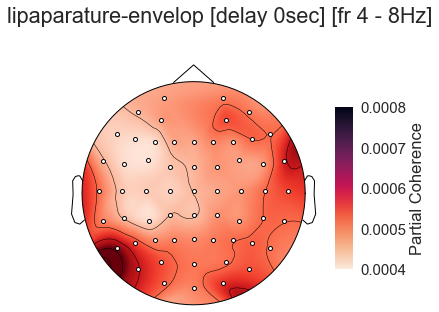

In [148]:
features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']

features = ['envelop']
Removedfeatures = ['lipaparature']

features = ['lipaparature']
Removedfeatures = ['envelop']

condition = ['All']
delay = [0]
freq_band = [ 'fr 4 - 8Hz']

debiased_coh = []
original_coh = []

for s in subject_name:
    A = data.loc[features,delay,Removedfeatures,delay,freq_band,condition,s]['Data'].get_values()
    B = data_surrogate.loc[features,delay,Removedfeatures,delay,freq_band,condition,s]['mean_data'].get_values()
    original_coh.append(A[0])
    A = A[0] - B[0]
    debiased_coh.append(A)
    
debiased_coh = np.asarray(debiased_coh)
original_coh = np.asarray(original_coh)

P = [0] * 59
T = [0] * 59
for ch in range(0,59):
    t,p = scipy.stats.wilcoxon(debiased_coh[:,ch])
    P[ch] = p/2
    T[ch] = t

mask, adj_p = fdr_correction(P, alpha=0.05, method='indep')  
A = original_coh.mean(axis=0)
vmin = np.round(min(A),decimals=4)
vmax = np.round(max(A),decimals=4)
df = pd.DataFrame({'Data':[A],'mask':[mask],'p-value':[P],'t-stat':[T]})

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].any() 
    mask = data['mask'].any()
    mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax,mask = mask)

sns.set(style="darkgrid")
sns.set(font_scale=1.5)
fg = sns.FacetGrid(df,margin_titles=True,size=5)
b = fg.map_dataframe(draw_heatmap, 'Data')
b = b.set_xlabels('')
#b.fig.subplots_adjust(top=0.7)
b.fig.subplots_adjust(right=0.8)
b.fig.suptitle(features[0]+'-'+Removedfeatures[0]+' [delay '+str(delay[0])+'sec] ['+freq_band[0]+']')

cbar_ax = b.fig.add_axes([0.82,0.25,0.05,0.45]) # [left, bottom, width, height] 
#colorbar
cmap = plt.get_cmap()
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap.reversed(), norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax,label='Partial Coherence')

# cluster permutation between two features

In [285]:
def compute_cluster_permutation_coherence_surrogate(condition1,condition2):
    #condition1 = condition1[:, :, np.newaxis]
    #condition2 = condition2[:, :, np.newaxis]
    fname = os.path.dirname(os.path.dirname(os.getcwd())) + '/fieldtrip_eeg_clean\mat/acticap-64ch-standard2_ferrara_neighb_for_mne.mat'
    connectivity ,ch_names = mne.channels.read_ch_connectivity(fname)
    
    threshold_tfce = dict(start=0, step=0.2)

    T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test([condition1, condition2],
                                                                n_permutations=1000, out_type='indices',
                                                                     threshold=threshold_tfce,
                                                                       connectivity = connectivity)

    T_obs_plot = np.nan * np.ones_like(T)
    for c, p_val in zip(clusters, cluster_p_values):
        if p_val <= 0.05:
            T_obs_plot[c] = T[c]

    mask = np.invert(np.isnan(T_obs_plot))
    return T_obs, mask


In [286]:
# partial coherence
save_path = data_path + '/data/partialCoh/PartialCoh-removedFirst-'+ str(remove_first)+'.pkl'
data=pd.read_pickle(save_path)
data.set_index(['Feature','FeatureDelay','RemoveFeature','RemoveFeatureDelay',
                        'Freq','Condition','Subject'], inplace=True)
data.sort_index(inplace=True)
a  = data['Data'].apply(lambda x: np.mean(x))
data['partialCoh'] = pd.Series(a, index=data.index)

In [287]:
features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']

features = ['envelop']
Removedfeatures = ['lipaparature']

condition = ['All']
freq_band = [ 'fr 1 - 3Hz']
d = np.arange(-3,6) / 10

frame1 =[]
frame2 =[]
for delay in d:
    condition1 = []
    condition2 = []

    for s in subject_name:
        A = data.loc[features,delay,Removedfeatures,delay,freq_band,condition,s]['Data'].get_values()
        B = data.loc[Removedfeatures,delay,features,delay,freq_band,condition,s]['Data'].get_values()
        condition1.append(A[0])
        condition2.append(B[0])

    condition2 = np.asarray(condition2)
    condition1 = np.asarray(condition1)

    frame1.append(condition1)
    frame2.append(condition2)
    
condition2 = np.asarray(frame2)
condition1 = np.asarray(frame1)

condition1 = np.swapaxes(condition1,0,1)
condition2 = np.swapaxes(condition2,0,1)

T, mask = compute_cluster_permutation_coherence_surrogate(condition1,condition2)

delay = np.arange(-3,6) / 10
frame = []
for d in range(0,len(delay)):
    df = pd.DataFrame({'mask':[mask[d,:]],'Data':[T[d,:]],'Delay':delay[d]})
    frame.append(df)
df = pd.concat((frame),axis=0)

stat_fun(H1): min=0.000002 max=37.379091
Running initial clustering
Using 187 thresholds from 0.00 to 37.20 for TFCE computation (h_power=2.00, e_power=0.50)
Found 531 clusters
Permuting 999 times...
[....................................... ] 99.30%  \   Computing cluster p-values
Done.


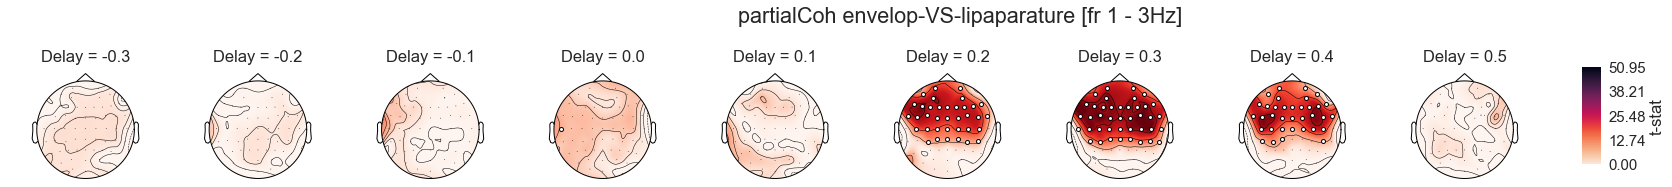

In [288]:
vmin = np.round(min(T.flatten()),decimals=2)
vmax = np.round(max(T.flatten()),decimals=2)

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].any() 
    mask = data['mask'].any()
    mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax,mask = mask)
    

sns.set(style="darkgrid")
sns.set(font_scale=1.5)
fg = sns.FacetGrid(df,col='Delay',margin_titles=True)
b = fg.map_dataframe(draw_heatmap, 'Data')
b = b.set_xlabels('')
b.fig.subplots_adjust(top=0.7)
b.fig.subplots_adjust(right=0.8)
b.fig.suptitle('partialCoh '+features[0]+'-VS-'+Removedfeatures[0]+' ['+freq_band[0]+']')
#b.fig.suptitle(features[0]+'-VS-'+Removedfeatures[0]+' [delay '+str(delay[0])+'sec] ['+freq_band[0]+']')

cbar_ax = b.fig.add_axes([0.82,0.25,0.01,0.45]) # [left, bottom, width, height] 
#colorbar
cmap = plt.get_cmap()
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap.reversed(), norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax,label='t-stat')    

stat_fun(H1): min=0.000009 max=16.203142
Running initial clustering
Using 82 thresholds from 0.00 to 16.20 for TFCE computation (h_power=2.00, e_power=0.50)
Found 59 clusters
Permuting 999 times...
[....................................... ] 99.30%  \   Computing cluster p-values
Done.


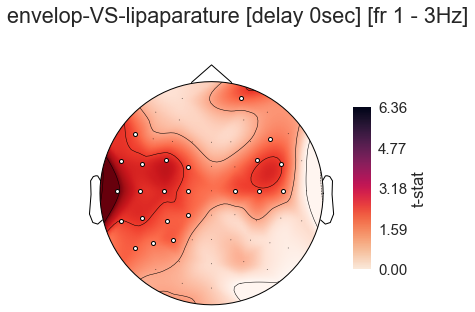

In [174]:
features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']

features = ['envelop']
Removedfeatures = ['lipaparature']

condition = ['All']
delay = [0]
freq_band = [ 'fr 1 - 3Hz']

condition1 = []
condition2 = []

for s in subject_name:
    A = data.loc[features,delay,Removedfeatures,delay,freq_band,condition,s]['Data'].get_values()
    B = data.loc[Removedfeatures,delay,features,delay,freq_band,condition,s]['Data'].get_values()
    condition1.append(A[0])
    condition2.append(B[0])
    
condition2 = np.asarray(condition2)
condition1 = np.asarray(condition1)

T, mask = compute_cluster_permutation_coherence_surrogate(condition1,condition2)
    
vmin = np.round(min(T),decimals=2)
vmax = np.round(max(T),decimals=2)
df = pd.DataFrame({'mask':[mask],'Data':[T]})

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].any() 
    mask = data['mask'].any()
    mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax,mask = mask)
    

sns.set(style="darkgrid")
sns.set(font_scale=1.5)
fg = sns.FacetGrid(df,margin_titles=True,size=5)
b = fg.map_dataframe(draw_heatmap, 'Data')
b = b.set_xlabels('')
#b.fig.subplots_adjust(top=0.7)
b.fig.subplots_adjust(right=0.8)
b.fig.suptitle(features[0]+'-VS-'+Removedfeatures[0]+' [delay '+str(delay[0])+'sec] ['+freq_band[0]+']')

cbar_ax = b.fig.add_axes([0.82,0.25,0.05,0.45]) # [left, bottom, width, height] 
#colorbar
cmap = plt.get_cmap()
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap.reversed(), norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax,label='t-stat')    

In [281]:
# coherence
save_path = data_path + '/data/coherence/Coh-removedFirst-'+ str(remove_first)+'.pkl'
data=pd.read_pickle(save_path)
data.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)

In [283]:
features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']

features = ['envelop','lipaparature']
condition = ['All']
delay = [0]
freq_band = [ 'fr 1 - 3Hz']
d = np.arange(-3,6) / 10

frame1 =[]
frame2 =[]
for delay in d:
    condition1 = []
    condition2 = []

    for s in subject_name:
        A = data.loc[features[0],freq_band,condition,delay,s]['Data'].get_values()
        B = data.loc[features[1],freq_band,condition,delay,s]['Data'].get_values()
        condition1.append(A[0])
        condition2.append(B[0])

    condition2 = np.asarray(condition2)
    condition1 = np.asarray(condition1)

    frame1.append(condition1)
    frame2.append(condition2)
    
condition2 = np.asarray(frame2)
condition1 = np.asarray(frame1)

condition1 = np.swapaxes(condition1,0,1)
condition2 = np.swapaxes(condition2,0,1)
T, mask = compute_cluster_permutation_coherence_surrogate(condition1,condition2)

delay = np.arange(-3,6) / 10
frame = []
for d in range(0,len(delay)):
    df = pd.DataFrame({'mask':[mask[d,:]],'Data':[T[d,:]],'Delay':delay[d]})
    frame.append(df)
df = pd.concat((frame),axis=0)


stat_fun(H1): min=0.000001 max=46.278078
Running initial clustering
Using 232 thresholds from 0.00 to 46.20 for TFCE computation (h_power=2.00, e_power=0.50)
Found 531 clusters
Permuting 999 times...
[....................................... ] 99.30%  \   Computing cluster p-values
Done.


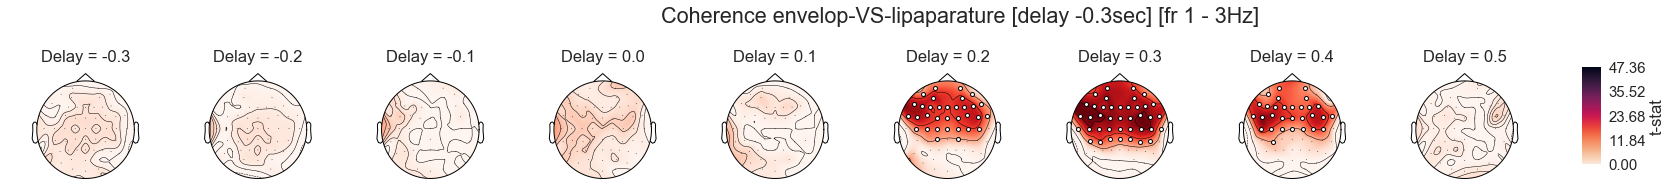

In [284]:
vmin = np.round(min(T.flatten()),decimals=2)
vmax = np.round(max(T.flatten()),decimals=2)

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].any() 
    mask = data['mask'].any()
    mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax,mask = mask)
    

sns.set(style="darkgrid")
sns.set(font_scale=1.5)
fg = sns.FacetGrid(df,col='Delay',margin_titles=True)
b = fg.map_dataframe(draw_heatmap, 'Data')
b = b.set_xlabels('')
b.fig.subplots_adjust(top=0.7)
b.fig.subplots_adjust(right=0.8)
b.fig.suptitle('Coherence '+features[0]+'-VS-'+features[1]+' [delay '+str(delay[0])+'sec] ['+freq_band[0]+']')
#b.fig.suptitle('Coherence '+features[0]+'-VS-'+features[1]+' [delay '+str(delay[0])+'sec] ['+freq_band[0]+']')

cbar_ax = b.fig.add_axes([0.82,0.25,0.01,0.45]) # [left, bottom, width, height] 
#colorbar
cmap = plt.get_cmap()
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap.reversed(), norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax,label='t-stat')

stat_fun(H1): min=0.011909 max=16.714542
Running initial clustering
Using 84 thresholds from 0.00 to 16.60 for TFCE computation (h_power=2.00, e_power=0.50)
Found 59 clusters
Permuting 999 times...
[....................................... ] 99.30%  \   Computing cluster p-values
Done.


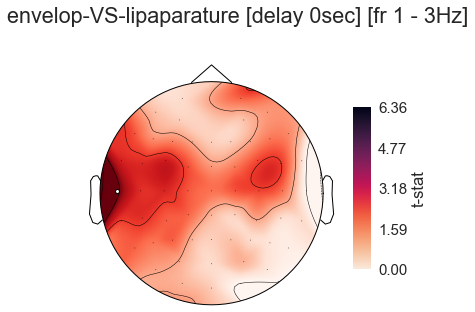

In [171]:
features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']

features = ['envelop','lipaparature']
condition = ['All']
delay = [0]
freq_band = [ 'fr 1 - 3Hz']

condition1 = []
condition2 = []

for s in subject_name:
    A = data.loc[features[0],freq_band,condition,delay,s]['Data'].get_values()
    B = data.loc[features[1],freq_band,condition,delay,s]['Data'].get_values()
    condition1.append(A[0])
    condition2.append(B[0])
    
condition2 = np.asarray(condition2)
condition1 = np.asarray(condition1)

T, mask = compute_cluster_permutation_coherence_surrogate(condition1,condition2)

vmin = np.round(min(T),decimals=2)
vmax = np.round(max(T),decimals=2)
df = pd.DataFrame({'mask':[mask],'Data':[T]})

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].any() 
    mask = data['mask'].any()
    mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax,mask = mask)
    

sns.set(style="darkgrid")
sns.set(font_scale=1.5)
fg = sns.FacetGrid(df,margin_titles=True,size=5)
b = fg.map_dataframe(draw_heatmap, 'Data')
b = b.set_xlabels('')
#b.fig.subplots_adjust(top=0.7)
b.fig.subplots_adjust(right=0.8)
b.fig.suptitle(features[0]+'-VS-'+features[1]+' [delay '+str(delay[0])+'sec] ['+freq_band[0]+']')

cbar_ax = b.fig.add_axes([0.82,0.25,0.05,0.45]) # [left, bottom, width, height] 
#colorbar
cmap = plt.get_cmap()
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap.reversed(), norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax,label='t-stat')

Text(0.5,0.98,'envelop - fr 1 - 3Hz')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000000000AF18E18> (for post_execute):


ValueError: too many values to unpack (expected 1)

ValueError: too many values to unpack (expected 1)

In [123]:



sns.set(style="darkgrid")
sns.set(font_scale=1.5)
fg = sns.FacetGrid(df,margin_titles=True,size=5)
b = fg.map_dataframe(draw_heatmap, 'Data')
b = b.set_xlabels('')
#b.fig.subplots_adjust(top=0.7)
b.fig.subplots_adjust(right=0.8)
b.fig.suptitle(features[0]+' - '+freq_band[0])

cbar_ax = b.fig.add_axes([0.82,0.25,0.05,0.45]) # [left, bottom, width, height] 
#colorbar
cmap = plt.get_cmap()
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap.reversed(), norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax,label='t-stat')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000000000AF18E18> (for post_execute):


ValueError: too many values to unpack (expected 1)

ValueError: too many values to unpack (expected 1)

In [77]:
features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']

features = ['lipaparature']
condition = ['All']
d = np.arange(-5,6) / 10
freq_band = [ 'fr 1 - 3Hz']

frame =[]
for delay in d:
    debiased_coh = []
    original_coh = []

    for s in subject_name:
        A = data.loc[features,freq_band,condition,delay,s]['Data'].get_values()
        B = data_surrogate.loc[features,freq_band,condition,delay,s]['mean_data'].get_values()
        original_coh.append(A[0])
        A = A[0] - B[0]
        debiased_coh.append(A)

    debiased_coh = np.asarray(debiased_coh)
    original_coh = np.asarray(original_coh)


    P = [0] * 59
    for ch in range(0,59):
        t,p = scipy.stats.normaltest(debiased_coh[:,ch])
        if p<0.05:
            P[ch] = np.round(p,decimals=4)
    
    
    frame.append(np.count_nonzero(P))


In [78]:
frame = np.asarray(frame)
frame

array([ 7,  8,  8, 16,  4,  8,  5, 17, 22,  8,  2])

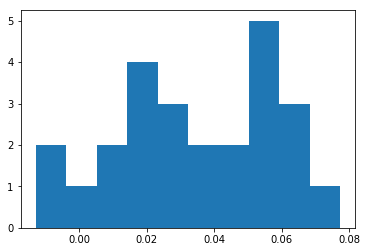

In [155]:
ch = 34
a = plt.hist(debiased_coh[:,ch]) # plotting by columns
#a = plt.axvline(x=A[0][ch]) # plotting by columns

In [96]:
features = ['envelop','lipaparature']
# putit into one file    
A=[]
a = ('-').join(features)
for s in subject_name:
    save_path = data_path + '/data/SurrogateCoherence/SurrogateCoherence-removedFirst-' \
    +str(remove_first)+'-'+a+'-'+s+'.pkl'
    A.append(pd.read_pickle(save_path))

data = pd.concat((A),axis=0)
save_path = data_path + '/data/SurrogateCoherence/SurrogateCoherence-removedFirst-' \
    +str(remove_first)+'-'+a+'.pkl'  
data.to_pickle(save_path)  


In [ ]:
fname = os.path.dirname(os.path.dirname(os.getcwd())) + '/fieldtrip_eeg_clean\mat/acticap-64ch-standard2_ferrara_neighb_for_mne.mat'
connectivity ,ch_names = mne.channels.read_ch_connectivity(fname)

threshold_tfce = dict(start=0, step=0.2)

T, clusters, cluster_p_values, H0 = permutation_cluster_test([condition1, condition2],
                                                            n_permutations=500, out_type='indices',
                                                                 #threshold=threshold_tfce,
                                                                   connectivity = connectivity)
T_obs_plot = np.nan * np.ones_like(T)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.05:
        T_obs_plot[c] = T[c]
        
mask = np.invert(np.isnan(T_obs_plot))

In [ ]:
fi = []
for fr in range(0,len(iter_freqs)):
    fi.append(iter_freqs[fr][1])
    
    a = pd.DataFrame(data.reset_index())
freq = a.Freq.unique()
fi = freq[freq <15]
#fi = freq[0:39:2]

In [ ]:
p = [0] * 59
for ch in range(0,59):
    a = len(np.where(B[0][ch,:]<A[0][ch])[0])/no_surrogates
    p[ch] = a[0]